In [1]:
import dill
import numpy as np
import sys
import os
np.set_printoptions(threshold=sys.maxsize)


In [2]:
f_in = open("density_matrix_t_series.pkl","rb")
matrix_test = dill.load(f_in)
f_in.close()
density_matrix_t_series = matrix_test


f_in = open("grid_matrix.pkl","rb")
matrix_test = dill.load(f_in)
f_in.close()
grid_matrix = matrix_test

In [3]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#np.seterr(divide='ignore', invalid='ignore')
scaler = StandardScaler()
scaler2 = MinMaxScaler()
dm_series_np = np.array(density_matrix_t_series)
flattened_matrix_np = np.reshape(dm_series_np, (dm_series_np.shape[0]*dm_series_np.shape[1], dm_series_np.shape[1]))

normalized_matrices = scaler.fit_transform(flattened_matrix_np)
normalized_matrices = scaler2.fit_transform(normalized_matrices)

inverseTcheck = scaler2.inverse_transform(normalized_matrices)
inverseTcheck = scaler.inverse_transform(inverseTcheck)

In [4]:
x_train = normalized_matrices[0:-normalized_matrices.shape[1]].copy()
y_train = normalized_matrices[normalized_matrices.shape[1]-1:-1].copy()
print(x_train.shape)
print(y_train.shape)

(144500, 500)
(144500, 500)


In [5]:
#x_train2 = np.reshape(x_train, (int(x_train.shape[0]/x_train.shape[1]), x_train.shape[1], x_train.shape[1]))
x_train2 = np.reshape(x_train, (int(x_train.shape[0]/x_train.shape[1]), x_train.shape[1], x_train.shape[1]))
x_train2 = np.reshape(x_train, (x_train2.shape[0] * x_train2.shape[1], 1, x_train2.shape[2]))
y_train2 = np.reshape(y_train, (int(y_train.shape[0]/y_train.shape[1]), y_train.shape[1], y_train.shape[1]))
y_train2 = np.reshape(y_train, (y_train2.shape[0]*y_train2.shape[1], y_train2.shape[2]))
print(x_train2.shape)
print(y_train2.shape)
x_train2.shape[2]

(144500, 1, 500)
(144500, 500)


500

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
import cartopy.crs as ccrs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow.keras as keras
import types
import tempfile
import os


def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', mode='w', delete=True, dir=os.getcwd()) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5',mode='r', delete=True, dir=os.getcwd()) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

tf.keras.backend.clear_session()
make_keras_picklable()

In [7]:
model = Sequential()
model.add(LSTM(1024, input_shape= (1, x_train2.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(1024, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(x_train2.shape[2], activation='selu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 1024)           6246400   
_________________________________________________________________
dropout (Dropout)            (None, 1, 1024)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 1024)           8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1024)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               5

In [8]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
#opt = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
#opt = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)

model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['accuracy'],
)

model.fit(x_train2,
          y_train2,
          epochs=1)

Train on 144500 samples
144500/144500 [==============================] - 138s 955us/sample - loss: 0.0213 - accuracy: 0.4719


In [29]:
f = open('model.pkl', "wb")
dill.dump(model, file=f)
f.close()

OSError: Unable to create file (unable to open file: name = 'C:\Users\Zhimin90\Documents\Chicago_Pothole_Tracker\CSV\tmpx5b7rsu9.hdf5', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

In [9]:
pred = model.predict(x_train2[-501:-1])
data = scaler.inverse_transform(scaler2.inverse_transform(pred))
print(type(data))
data2 = data.reshape((int(data.shape[0]/data.shape[1]), data.shape[1], data.shape[1]))
print(data2[-1].shape)

<class 'numpy.ndarray'>
(500, 500)


In [10]:
data2.shape

(1, 500, 500)

In [11]:
f_in2 = open("map_arr.pkl","rb")
map_arr = dill.load(f_in2)
f_in.close()

In [12]:
import matplotlib.pyplot as plt
grid_size = 500
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY


Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

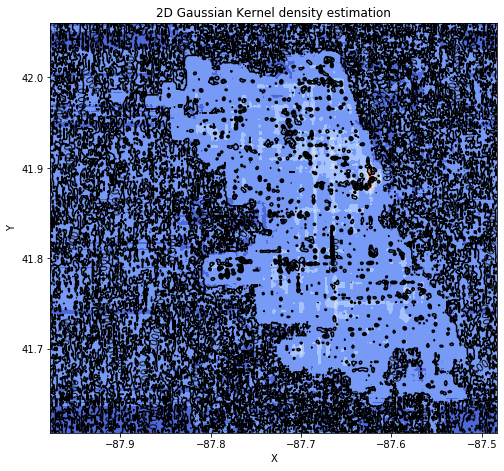

In [13]:
xx, yy = np.mgrid[xmin:xmax:(grid_size*1j), ymin:ymax:(grid_size*1j)]
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, data2[-1], cmap='coolwarm')
ax.imshow(np.rot90(data2[-1]), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, density_matrix_t_series[1], colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')


(41.60687, 42.06083)

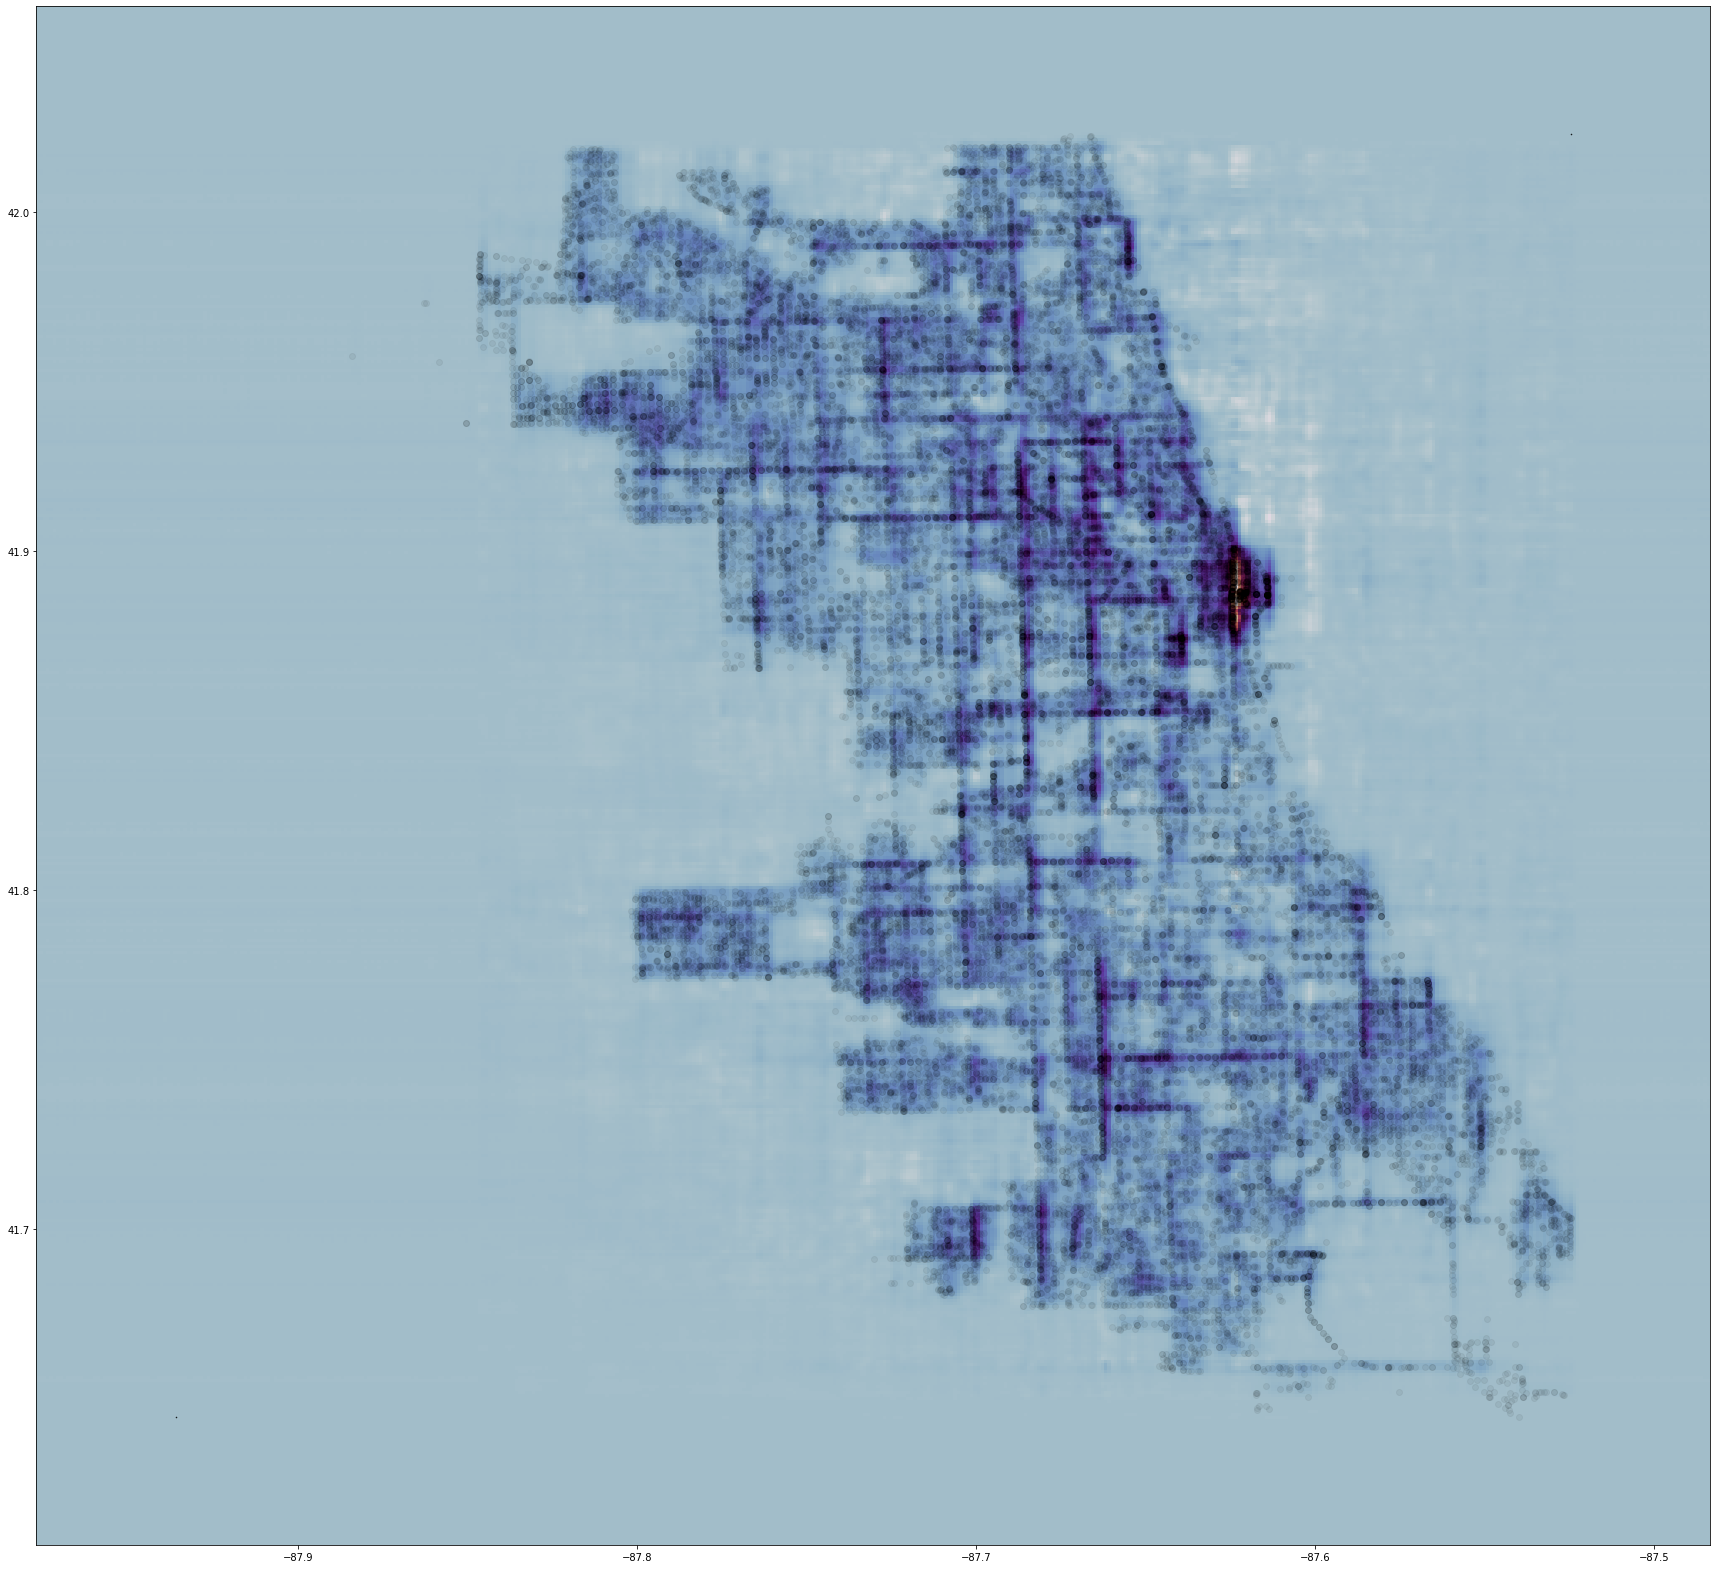

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [30, 30]
fig1, ax1 = plt.subplots()
ax1.scatter(x="LONGITUDE", y="LATITUDE", data=map_arr[-2], c="black", alpha=0.05)
ax1.imshow(np.rot90(data2[-1]), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])
ax1.plot(x, y, 'k.', markersize=1)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])


In [22]:
import pandas as pd
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

def predictor(model, data_in, grid, start_frame_date, end_frame_date, time_shift):
    xx, yy = grid
    offset = yy.shape[0]
    print("offset = yy.shape[0]" + str(offset))
    xx = xx.ravel()
    yy = yy.ravel()
    xdelta = abs(xx[1] - xx[1+offset])
    ydelta = abs(yy[0] - yy[1+offset])
    print("xdelta"+str(xdelta))
    print("ydelta"+str(ydelta))
    columns = [ 'start_date', 'end_date', 'poly_coordinate', 'density']
    
    pred = model.predict(data_in)
    data = scaler.inverse_transform(scaler2.inverse_transform(pred))
    data_reshaped = data.reshape((int(data.shape[0]/data.shape[1]), data.shape[1], data.shape[1]))
    print(data_reshaped.shape)
    #each cell is a density estimate from KDE that that has been aggregated by number of potholes over time
    #This time interval of density cell is input frame time + timeshift the target frame in the model that has shifted forward by
    
    row_dict = {'start_date' : None, 'end_date' : None, 'poly_coordinate': None, 'density': 0}
    #append = pd.DataFrame(columns=columns)
    dict_list = []
    for t, matrix in enumerate(data_reshaped):
        xy_matrix = np.flip(np.rot90(matrix),0)
        print(xy_matrix.shape)
        row_dict['start_date'] = pd.to_datetime(start_frame_date) + timedelta(days=(time_shift*(t+1)))
        row_dict['end_date'] = pd.to_datetime(end_frame_date) + timedelta(days=(time_shift*(t+1)))
        
        for i, row in enumerate(xy_matrix):
            for j, cell in enumerate(row):
                pos_index = i + j*xy_matrix.shape[1]
                #generate density cell (square) polycoordinate [[cxmin,cymin],[cxmax, cymin],[cxmin, cymax],[cxmax, cymax]]
                row_dict['poly_coordinate'] = [[xx[pos_index],yy[pos_index]],[xx[pos_index]+xdelta,yy[pos_index]],[xx[pos_index]+xdelta,yy[pos_index]+ydelta], [xx[pos_index],yy[pos_index]+ydelta]]
                row_dict['density'] = cell
                dict_list.append(row_dict.copy())

    return pd.DataFrame(dict_list)

In [23]:
start_frame_date = '2017-11-01 00:00:00'
end_frame_date = '2018-11-01 00:00:00'
time_shift = 10 #days
dataframe = predictor(model,x_train2[-501:-1], (xx, yy), start_frame_date, end_frame_date, time_shift)

offset = yy.shape[0]500
xdelta0.0009898196392725822
ydelta0.0009097394789563396
(1, 500, 500)
(500, 500)


In [24]:
dataframe

,start_date,end_date,poly_coordinate,density
0,2017-11-11,2018-11-11,"[[-87.97726, 41.60687], [-87.97627018036073, 4...",-4.523966e-16
1,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.60687], [-87.97528036...",-4.490958e-16
2,2017-11-11,2018-11-11,"[[-87.97528036072144, 41.60687], [-87.97429054...",-4.462013e-16
3,2017-11-11,2018-11-11,"[[-87.97429054108217, 41.60687], [-87.97330072...",-4.430034e-16
4,2017-11-11,2018-11-11,"[[-87.97330072144288, 41.60687], [-87.97231090...",-4.471651e-16
...,...,...,...,...
249995,2017-11-11,2018-11-11,"[[-87.48729927855712, 42.06083], [-87.48630945...",-4.791983e-16
249996,2017-11-11,2018-11-11,"[[-87.48630945891783, 42.06083], [-87.48531963...",-4.677685e-16
249997,2017-11-11,2018-11-11,"[[-87.48531963927856, 42.06083], [-87.48432981...",-4.821603e-16
249998,2017-11-11,2018-11-11,"[[-87.48432981963927, 42.06083], [-87.48334, 4...",-4.709800e-16


In [25]:
dataframe.iloc[0:250000].to_csv("2017-11-11_4frames_all")

In [26]:
dataframe['poly_coordinate'].iloc[0]
#dataframe['density'].max()

[[-87.97726, 41.60687],
 [-87.97627018036073, 41.60687],
 [-87.97627018036073, 41.60777973947896],
 [-87.97726, 41.60777973947896]]

In [46]:
from ast import literal_eval

In [47]:
df_test = pd.read_csv("C:\\Users\\Zhimin90\\Documents\\CPT\\Chicago_Pothole_Tracker\\CSV\\2017-11-11_4frames_test.csv",converters={"poly_coordinate": literal_eval})

In [48]:
df_test


,Unnamed: 0,start_date,end_date,poly_coordinate,density
0,0,2017-11-11,2018-11-11,"[[-87.97726, 42.06083], [-87.97627018036073, 4...",-2.565649e-16
1,1,2017-11-11,2018-11-11,"[[-87.97726, 42.05992026052105], [-87.97627018...",-2.552543e-16
2,2,2017-11-11,2018-11-11,"[[-87.97726, 42.05901052104209], [-87.97627018...",-2.514947e-16
3,3,2017-11-11,2018-11-11,"[[-87.97726, 42.05810078156313], [-87.97627018...",-2.609710e-16
4,4,2017-11-11,2018-11-11,"[[-87.97726, 42.05719104208417], [-87.97627018...",-2.553703e-16
...,...,...,...,...,...
995,995,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.61050895791583], [-87...",-1.488939e-16
996,996,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.60959921843688], [-87...",-1.559645e-16
997,997,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.60868947895791], [-87...",-1.601375e-16
998,998,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.60777973947896], [-87...",-1.531697e-16


In [50]:
for index, row in df_test.iterrows():
        #print(row['poly_coordinate'])
        start_date = row['start_date']
        end_date = row['end_date']
        #print(row['poly_coordinate'])
        poly_coordinate = ( ((row['poly_coordinate'][0][0], row['poly_coordinate'][0][1]), \
                             (row['poly_coordinate'][1][0], row['poly_coordinate'][1][1]), \
                             (row['poly_coordinate'][2][0], row['poly_coordinate'][2][1]), \
                             (row['poly_coordinate'][3][0], row['poly_coordinate'][3][1])) )
        density = row['density']
        

In [52]:
poly_coordinate[0][1]

41.60687